# AquaCrop-OSPy: Bridging the gap between research and practice in crop-water modelling


This series of notebooks provides users with an introduction to AquaCrop-OSPy, an open-source Python implementation of the U.N. Food and Agriculture Organization (FAO) AquaCrop model. AquaCrop-OSPy is accompanied by a series of Jupyter notebooks, which guide users interactively through a range of common applications of the model. Only basic Python experience is required, and the notebooks can easily be extended and adapted by users for their own applications and needs.


This notebook series consists of four parts:

1.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_1.ipynb>Running an AquaCrop-OSPy model</a>
2.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_2.ipynb>Estimation of irrigation water demands</a>
3.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_3.ipynb>Optimisation of irrigation management strategies</a>
4.  <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_4.ipynb>Projection of climate change impacts</a>


## Install and import AquaCrop-OSPy

Install and import aquacrop as we did in Notebook 1.

In [2]:
!pip install aquacrop==0.1.0

from aquacrop.classes import    *
from aquacrop.core import       *

from google.colab import output
output.clear()

# Notebook 2: Estimating irrigation water demands under different irrigation strategies

In Notebook 1, we learned how to create an `AquaCropModel` by selecting a weather data file, `SoilClass`, `CropClass` and `InitWCClass` (initial water content). In this notebook, we show how AquaCrop-OSPy can be used to explore impacts of different irrigation management strategies on water use and crop yields. The example workflow below shows how different irrigation management practices can be defined in the model, and resulting impacts on water use productivity explored to support efficient irrigation scheduling and planning decisions.

We start by creating a weather DataFrame containing daily measurements of minimum temperature, maximum temperature, precipitation and reference evapotranspiration. In this example we will use the built in file containing weather data from Champion, Nebraska, USA. (**link**). 


In [3]:
path = get_filepath('champion_climate.txt')
wdf = prepare_weather(path)
wdf

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,-21.11,3.33,0.0,1.59,1982-01-01
1,-10.00,0.56,0.0,0.86,1982-01-02
2,-11.67,-2.22,0.0,0.72,1982-01-03
3,-12.22,7.22,0.0,1.71,1982-01-04
4,-14.44,-1.11,0.0,0.92,1982-01-05
...,...,...,...,...,...
13509,-7.93,-2.01,0.0,0.52,2018-12-27
13510,-15.52,-5.35,0.0,0.62,2018-12-28
13511,-17.23,2.76,0.0,1.37,2018-12-29
13512,-11.28,10.96,0.0,2.13,2018-12-30


We will run a 37 season simulation starting at 1982-05-01 and ending on 2018-10-30

In [4]:
sim_start = '1982/05/01'
sim_end = '2018/10/30'

Next we must define a soil, crop and initial soil water content. This is done by creating a `SoilClass`, `CropClass` and `InitWCClass`. In this example we select a sandy loam soil, a Maize crop, and with the soil initially at Field Capacity.

In [5]:
soil= SoilClass('SandyLoam')

crop = CropClass('Maize',PlantingDate='05/01')

initWC = InitWCClass(value=['FC'])


Irrigation management parameters are selected by creating an `IrrMngtClass` object. With this class we can specify a range of different irrigation management strategies. The 6 different strategies can be selected using the `IrrMethod` argument when creating the class. These strategies are as follows:


*   `IrrMethod=0`: Rainfed (no irrigation)
*   `IrrMethod=1`: Irrigation is triggered if soil water content drops below a specified threshold (or four thresholds representing four major crop growth stages (emergence, canopy growth, max canopy, senescence).
*   `IrrMethod=2`: Irrigation is triggered every N days
*   `IrrMethod=3`: Predefined irrigation schedule
*   `IrrMethod=4`: Net irrigation (maintain a soil-water level by topping up all compartments daily)
*   `IrrMethod=5`: Constant depth applied each day


The full list of parameters you can edit are:

Variable Name | Type | Description | Default
--- | --- | --- | ---
IrrMethod| `int` | Irrigation method: | 0
 || 0 : rainfed | 
 || 1 : soil moisture targets
 || 2 : set time interval | 
 || 3: predefined schedule | 
 || 4: net irrigation | 
 || 5: constant depth | 
SMT | `list[float]` | Soil moisture targets (%TAW) to maintain in each growth stage  | [100,100,100,100]
|| (only used if irrigation method is equal to 1) |
IrrInterval  | `int` | Irrigation interval in days | 3
|| (only used if irrigation method is equal to 2) |
Schedule | `pandas.DataFrame` | DataFrame containing dates and depths | None
|| (only used if irrigation method is equal to 3) |
NetIrrSMT | `float` | Net irrigation threshold moisture level (% of TAW that will be maintained) | 80.
|| (only used if irrigation method is equal to 4) |
depth  | `float` | constant depth to apply on each day | 0.
|| (only used if irrigation method is equal to 5) |
WetSurf | `int` | Soil surface wetted by irrigation (%) | 100
AppEff | `int` |  Irrigation application efficiency (%) | 100
MaxIrr |  `float` | Maximum depth (mm) that can be applied each day | 25
MaxIrrSeason |  `float` | Maximum total irrigation (mm) that can be applied in one season | 10_000




For the purposes of this demonstration we will investigate the yields and irrigation applied for a range of constant soil-moisture thresholds. Meaning that all 4 soil-moisture thresholds are equal. These irrigation strategies will be compared over a 37 year period. The cell below will create and run an `AquaCropModel` for each irrigation strategy and save the final output. 

In [90]:
# define labels to help after
labels=[]

outputs=[]
for smt in range(0,110,20):
    crop.Name = str(smt) # add helpfull label
    labels.append(str(smt))
    irr_mngt = IrrMngtClass(IrrMethod=1,SMT=[smt]*4) # specify irrigation management
    model = AquaCropModel(sim_start,sim_end,wdf,soil,crop,InitWC=initWC,IrrMngt=irr_mngt) # create model
    model.initialize() # initilize model
    model.step(till_termination=True) # run model till the end
    outputs.append(model.Outputs.Final) # save results

Combine results so that they can be easily visualized.

In [91]:
dflist=outputs
labels[0]='Rainfed'
outlist=[]
for i in range(len(dflist)):
    temp = pd.DataFrame(dflist[i][['Yield','Tirr']])
    temp['label']=labels[i]
    outlist.append(temp)

all_outputs = pd.concat(outlist,axis=0)

In [92]:
# combine all results
results=pd.concat(outlist)

Use `matplotlib` and `seaborn` to show the range of yields and total irrigation for each strategy over the simulation years.

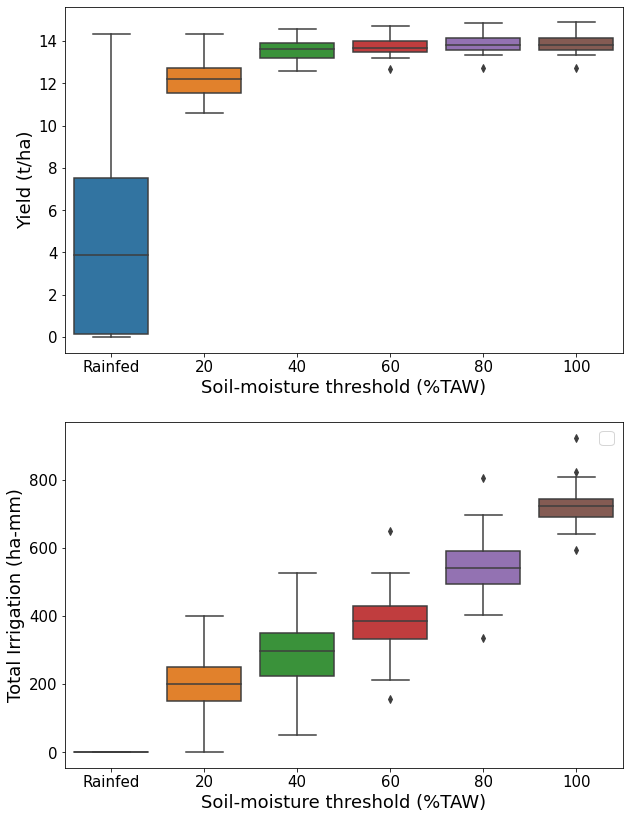

In [95]:
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# create figure consisting of 2 plots
fig,ax=plt.subplots(2,1,figsize=(10,14))

# create two box plots
sns.boxplot(data=results,x='label',y='Yield',ax=ax[0])
sns.boxplot(data=results,x='label',y='Tirr',ax=ax[1])

# labels and font sizes
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Soil-moisture threshold (%TAW)',fontsize=18)
ax[0].set_ylabel('Yield (t/ha)',fontsize=18)

ax[1].tick_params(labelsize=15)
ax[1].set_xlabel('Soil-moisture threshold (%TAW)',fontsize=18)
ax[1].set_ylabel('Total Irrigation (ha-mm)',fontsize=18)

plt.legend(fontsize=18)


# Appendix A: Other types of irrigation strategy

Testing different irrigation strategies is as simple as creating multiple `IrrMngtClass` objects. The **first** strategy we will test is rainfed growth (no irrigation).

In [99]:
# define irrigation management
rainfed = IrrMngtClass(IrrMethod=0)

The **second** strategy triggers irrigation if the root-zone water content drops below an irrigation threshold. There are 4 thresholds corresponding to four main crop growth stages (emergence, canopy growth, max canopy,  canopy senescence). The quantity of water applied is given by `min(depletion,MaxIrr)` where `MaxIrr` can be specified when creating an `IrrMngtClass`.

In [100]:
# irrigate according to 4 different soil-moisture thresholds
threshold4_irrigate = IrrMngtClass(IrrMethod=1,SMT=[40,60,70,30]*4)

The **third** strategy irrigates every `IrrInterval` days where the quantity of water applied is given by `min(depletion,MaxIrr)` where `MaxIrr` can be specified when creating an `IrrMngtClass`.

In [101]:
# irrigate every 7 days
interval_7 = IrrMngtClass(IrrMethod=2,IrrInterval=7)

The **fourth** strategy irrigates according to a predefined calendar. This calendar is defined as a pandas DataFrame and this example, we will create a calendar that irrigates on the first Tuesday of each month. 

In [102]:
import pandas as pd # import pandas library

all_days = pd.date_range(sim_start,sim_end) # list of all dates in simulation period

new_month=True
dates=[]
# iterate through all simulation days
for date in all_days:
    #check if new month
    if date.is_month_start:
        new_month=True

    if new_month:
        # check if tuesday (dayofweek=1)
        if date.dayofweek==1:
            #save date
            dates.append(date)
            new_month=False

Now we have a list of all the first Tuesdays of the month, we can create the full schedule.

In [103]:
depths = [25]*len(dates) # depth of irrigation applied
schedule=pd.DataFrame([dates,depths]).T # create pandas DataFrame
schedule.columns=['Date','Depth'] # name columns

schedule

,Date,Depth
0,1982-05-04,25
1,1982-06-01,25
2,1982-07-06,25
3,1982-08-03,25
4,1982-09-07,25
...,...,...
433,2018-06-05,25
434,2018-07-03,25
435,2018-08-07,25
436,2018-09-04,25


Then pass this schedule into our `IrrMngtClass`.

In [104]:
irrigate_schedule = IrrMngtClass(IrrMethod=3,Schedule=schedule)

The **fifth** strategy is net irrigation. This keeps the soil-moisture content above a specified level. This method differs from the soil moisture thresholds (second strategy) as each compartment is filled to field capacity, instead of water starting above the first compartment and filtering down. In this example the net irrigation mode will maintain a water content of 70% total available water.  

In [105]:
net_irrigation = IrrMngtClass(IrrMethod=4,NetIrrSMT=70)

Now its time to compare the strategies over the 37 year period. The cell below will create and run an `AquaCropModel` for each irrigation strategy and save the final output. 

In [106]:
# define labels to help after
labels=['rainfed','four thresholds','interval','schedule','net']
strategies = [rainfed,threshold4_irrigate,interval_7,irrigate_schedule,net_irrigation]

outputs=[]
for i,irr_mngt in enumerate(strategies): # for both irrigation strategies...
    crop.Name = labels[i] # add helpfull label
    model = AquaCropModel(sim_start,sim_end,wdf,soil,crop,InitWC=initWC,IrrMngt=irr_mngt) # create model
    model.initialize() # initilize model
    model.step(till_termination=True) # run model till the end
    outputs.append(model.Outputs.Final) # save results

The final strategy to show is for a custom irrigation strategy. This is one of the key features of AquaCrop-OSPy as users can define an a complex irrigation strategy that incorperates any external data, code bases or machine learning models. To showcase this feature, we will  define a function that will irrigate according to the follwong logic:

1) There will be no rain over the next 10 days -> Irrigate 10mm

2) There will be rain in the next 10 days but the soil is over 70% depleted -> Irrigate 10mm

3) Otherwise -> No irrigation

In [107]:
# function to return the irrigation depth to apply on next day
def get_depth(model):    
    t = model.ClockStruct.TimeStepCounter # current timestep
    # get weather data for next 7 days
    weather10 = model.weather[t+1:min(t+10+1,len(model.weather))]
    # if it will rain in next 7 days
    if sum(weather10[:,2])>0:
        # check if soil is over 70% depleted
        if t>0 and model.InitCond.Depletion/model.InitCond.TAW > 0.7:
            depth=10
        else:
            depth=0
    else:
        # no rain for next 10 days
        depth=10


    return depth

In [108]:
# create model with IrrMethod= Constant depth
crop.Name = 'weather' # add helpfull label

model = AquaCropModel(sim_start,sim_end,wdf,soil,crop,InitWC=initWC,
                      IrrMngt=IrrMngtClass(IrrMethod=5,)) 

model.initialize()

while not model.ClockStruct.ModelTermination:
    # get depth to apply
    depth=get_depth(model)
    
    model.ParamStruct.IrrMngt.depth=depth

    model.step()

In [109]:
outputs.append(model.Outputs.Final) # save results
labels.append('weather')

Combine results so that they can be easily visualized.

In [110]:
dflist=outputs
outlist=[]
for i in range(len(dflist)):
    temp = pd.DataFrame(dflist[i][['Yield','Tirr']])
    temp['label']=labels[i]
    outlist.append(temp)

all_outputs = pd.concat(outlist,axis=0)

In [111]:
# combine all results
results=pd.concat(outlist)

Use `matplotlib` and `seaborn` to show the range of yields and total irrigation for each strategy over the simulation years.

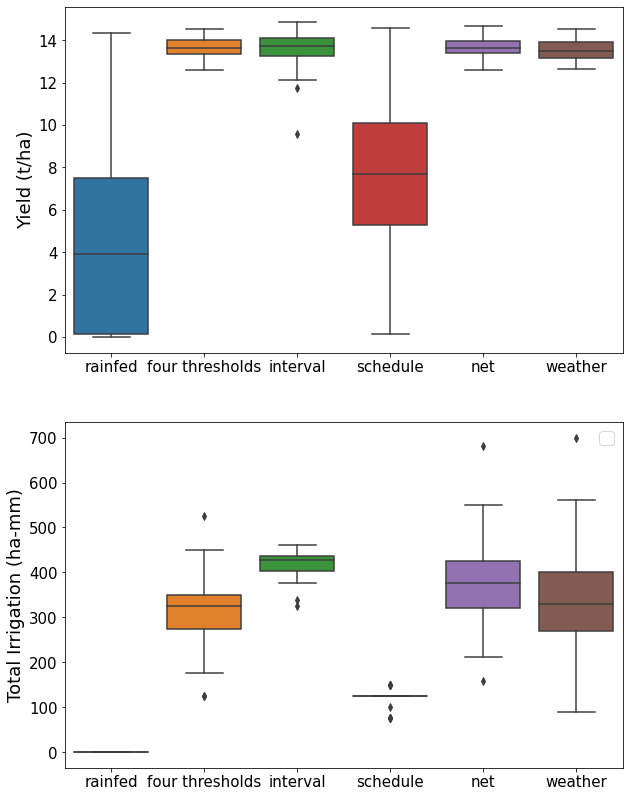

In [112]:
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# create figure consisting of 2 plots
fig,ax=plt.subplots(2,1,figsize=(10,14))

# create two box plots
sns.boxplot(data=results,x='label',y='Yield',ax=ax[0])
sns.boxplot(data=results,x='label',y='Tirr',ax=ax[1])

# labels and font sizes
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel(' ')
ax[0].set_ylabel('Yield (t/ha)',fontsize=18)

ax[1].tick_params(labelsize=15)
ax[1].set_xlabel(' ')
ax[1].set_ylabel('Total Irrigation (ha-mm)',fontsize=18)

plt.legend(fontsize=18)
